In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from pytorch_sklearn.neural_network.neural_network import NeuralNetwork
from pytorch_sklearn.neural_network.generative_network import CycleGAN, R2CGAN
from pytorch_sklearn.callbacks.predefined import Verbose, History, EarlyStopping
from pytorch_sklearn.utils.progress_bar import print_progress

from sonn.building_blocks import Downsample2d, Upsample2d
from sonn.norm_layers import LayerNormNLP2d
from sonn.superonn_final import SuperONN2d

from PIL import Image

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)
    
class SimpleR2CCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

        self.maxpool1 = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Linear(3, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        y =  self.conv3(x)

        c = self.maxpool1(y)
        c = c.view(c.size(0), -1)
        c = self.fc(c)
        return y, c
    
class KillerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.conv5 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        return self.conv5(x)
    
class KillerONN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SuperONN2d(3, 32, q=3, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.ln1   = LayerNormNLP2d(64)
        self.conv2 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.ln2   = LayerNormNLP2d(128)
        self.conv3 = SuperONN2d(128, 128, q=3, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.ln3   = LayerNormNLP2d(64)
        self.conv4 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.ln4   = LayerNormNLP2d(32)
        self.conv5 = SuperONN2d(32, 3, q=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = self.ln1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = self.ln2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = self.ln3(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        x = self.ln4(x)
        return self.conv5(x)
    
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = self.maxpool3(self.conv3(x))
        return x.view(-1, 1)

In [3]:
model = SimpleDiscriminator()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

In [4]:
X = torch.randn(10, 3, 32, 32)
y = torch.randn(10, 1)

In [5]:
net = NeuralNetwork(model, optim, crit)

In [6]:
net.callbacks

In [7]:
net.fit(
    train_X=X,
    train_y=y,
    max_epochs=50,
    callbacks=[Verbose(notebook=True)],
    metrics={'l1loss': nn.L1Loss(), 'l2loss': nn.MSELoss()},
)

Epoch 1/50
1/1 [====================] - train_loss: 0.514 - train_l1loss: 0.606 - train_l2loss: 0.514 - Time: 0.39 - ETA: 0.00
Epoch 2/50
1/1 [====================] - train_loss: 0.495 - train_l1loss: 0.611 - train_l2loss: 0.495 - Time: 0.00 - ETA: 0.00
Epoch 3/50
1/1 [====================] - train_loss: 0.466 - train_l1loss: 0.556 - train_l2loss: 0.466 - Time: 0.00 - ETA: 0.00
Epoch 4/50
1/1 [====================] - train_loss: 0.442 - train_l1loss: 0.512 - train_l2loss: 0.442 - Time: 0.00 - ETA: 0.00
Epoch 5/50
1/1 [====================] - train_loss: 0.411 - train_l1loss: 0.498 - train_l2loss: 0.411 - Time: 0.00 - ETA: 0.00
Epoch 6/50
1/1 [====================] - train_loss: 0.384 - train_l1loss: 0.501 - train_l2loss: 0.384 - Time: 0.00 - ETA: 0.00
Epoch 7/50
1/1 [====================] - train_loss: 0.362 - train_l1loss: 0.507 - train_l2loss: 0.362 - Time: 0.00 - ETA: 0.00
Epoch 8/50
1/1 [====================] - train_loss: 0.339 - train_l1loss: 0.493 - train_l2loss: 0.339 - Time: 0

In [8]:
net.predict(X)
gen = net.predict_generator(X)
for i in gen:
    print(i)
score = net.score(X, y)
print(score)

tensor([[ 0.0554],
        [ 1.2433],
        [ 0.2356],
        [-0.5996],
        [ 0.8150],
        [ 1.7691],
        [-0.1617],
        [-0.2483],
        [ 0.1505],
        [ 0.1829]], device='cuda:0')
tensor(0.0010)


In [6]:
class CycleGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], self.B[index]

In [7]:
class ZenDataset(Dataset):
    def __init__(self):
        self.Zen = tvt.ToTensor()(Image.open('zen2.jpg')).unsqueeze(0)
        self.Bro = tvt.ToTensor()(Image.open('bro.jpg')).unsqueeze(0)

    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        return self.Zen[index], self.Bro[index]

In [8]:
class STDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A = batch_out
        A, B = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [9]:
G_A = SimpleCNN()
G_B = SimpleCNN()
# G_A = KillerCNN()
# G_B = KillerCNN()
# G_A = KillerONN()
# G_B = KillerONN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [13]:
cycle_gan = CycleGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [14]:
cycle_gan_ds = CycleGANDataset()
zen_ds = ZenDataset()

In [15]:
std_metric = STDMetric()

In [16]:
cycle_gan.fit(
    train_X=cycle_gan_ds,
    max_epochs=200,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

Epoch 1/200
1/1 [====================] - train_loss: 2.260 - train_std: 10.603 - Time: 0.12 - ETA: 0.00
Epoch 2/200
1/1 [====================] - train_loss: 2.161 - train_std: 10.475 - Time: 0.09 - ETA: 0.00
Epoch 3/200
1/1 [====================] - train_loss: 2.092 - train_std: 10.345 - Time: 0.02 - ETA: 0.00
Epoch 4/200
1/1 [====================] - train_loss: 2.067 - train_std: 10.201 - Time: 0.02 - ETA: 0.00
Epoch 5/200
1/1 [====================] - train_loss: 2.048 - train_std: 10.056 - Time: 0.03 - ETA: 0.00
Epoch 6/200
1/1 [====================] - train_loss: 2.019 - train_std: 9.913 - Time: 0.02 - ETA: 0.00
Epoch 7/200
1/1 [====================] - train_loss: 1.997 - train_std: 9.768 - Time: 0.02 - ETA: 0.00
Epoch 8/200
1/1 [====================] - train_loss: 1.989 - train_std: 9.619 - Time: 0.02 - ETA: 0.00
Epoch 9/200
1/1 [====================] - train_loss: 1.991 - train_std: 9.469 - Time: 0.02 - ETA: 0.00
Epoch 10/200
1/1 [====================] - train_loss: 1.991 - train_

In [20]:
cycle_gan.G_elo, cycle_gan.D_elo

(0, 0)

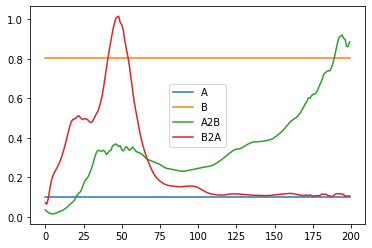

In [17]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()

In [21]:
preds = cycle_gan.predict(cycle_gan_ds)

In [21]:
plt.plot(cycle_gan.history.track['train_G_A_loss'], label='G_A_loss')
plt.plot(cycle_gan.history.track['train_G_B_loss'], label='G_B_loss')
plt.plot(cycle_gan.history.track['train_D_A_loss'], label='D_A_loss')
plt.plot(cycle_gan.history.track['train_D_B_loss'], label='D_B_loss')
# plt.ylim(0, 4)
plt.legend()
plt.show()

NameError: name 'cycle_gan' is not defined

In [19]:
preds = cycle_gan.predict(cycle_gan_ds)
score = cycle_gan.score(cycle_gan_ds)
print(score)
out_gen = cycle_gan.predict_generator(cycle_gan_ds)
for i in out_gen:
    print(i.__len__())

tensor([5.0278, 2.2271])
4


In [20]:
NeuralNetwork.save_class(cycle_gan, 'cycle_gan.pkl')

In [21]:
NeuralNetwork.load_class(cycle_gan, [], 'cycle_gan.pkl')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


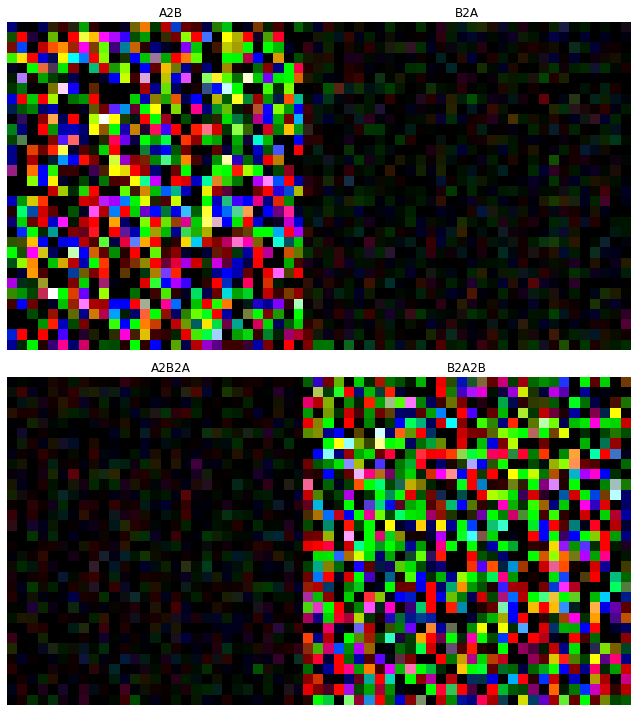

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(preds[0][0].permute(1, 2, 0).cpu(), vmin=preds[0][0].min(), vmax=preds[0][0].max())
plt.title('A2B')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(preds[1][0].permute(1, 2, 0).cpu(), vmin=preds[1][0].min(), vmax=preds[1][0].max())
plt.title('B2A')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(preds[2][0].permute(1, 2, 0).cpu(), vmin=preds[2][0].min(), vmax=preds[2][0].max())
plt.title('A2B2A')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(preds[3][0].permute(1, 2, 0).cpu(), vmin=preds[3][0].min(), vmax=preds[3][0].max())
plt.title('B2A2B')
plt.axis('off')
plt.gcf().tight_layout(w_pad=-10)
plt.show()

In [24]:
[pred.std() for pred in preds]

[tensor(0.1812, device='cuda:0'),
 tensor(0.6882, device='cuda:0'),
 tensor(0.0750, device='cuda:0'),
 tensor(0.5739, device='cuda:0')]

In [7]:
class R2CGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], 0, self.B[index], 1

In [8]:
class SimpleR2CCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

        self.maxpool1 = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Linear(3, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        y =  self.conv3(x)

        c = self.maxpool1(y)
        c = c.view(c.size(0), -1)
        c = self.fc(c)
        
        return y, c

In [9]:
class R2CSTDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A = batch_out
        A, yA, B, yB = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [10]:
G_A = SimpleR2CCNN()
G_B = SimpleR2CCNN()
# G_A = KillerCNN()
# G_B = KillerCNN()
# G_A = KillerONN()
# G_B = KillerONN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [11]:
r2c_gan = R2CGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [13]:
r2c_gan_ds = R2CGANDataset()

In [14]:
std_metric = R2CSTDMetric()

In [19]:
r2c_gan.fit(
    train_X=r2c_gan_ds,
    max_epochs=200,
    batch_size=10,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

Epoch 401/600
1/1 [====================] - train_loss: 1.654 - train_std: 3.375 - Time: 0.09 - ETA: 0.00
Epoch 402/600
1/1 [====================] - train_loss: 1.652 - train_std: 3.380 - Time: 0.22 - ETA: 0.00
Epoch 403/600
1/1 [====================] - train_loss: 1.653 - train_std: 3.381 - Time: 0.03 - ETA: 0.00
Epoch 404/600
1/1 [====================] - train_loss: 1.659 - train_std: 3.389 - Time: 0.03 - ETA: 0.00
Epoch 405/600
1/1 [====================] - train_loss: 1.654 - train_std: 3.400 - Time: 0.03 - ETA: 0.00
Epoch 406/600
1/1 [====================] - train_loss: 1.658 - train_std: 3.400 - Time: 0.03 - ETA: 0.00
Epoch 407/600
1/1 [====================] - train_loss: 1.650 - train_std: 3.398 - Time: 0.03 - ETA: 0.00
Epoch 408/600
1/1 [====================] - train_loss: 1.658 - train_std: 3.396 - Time: 0.03 - ETA: 0.00
Epoch 409/600
1/1 [====================] - train_loss: 1.657 - train_std: 3.399 - Time: 0.03 - ETA: 0.00
Epoch 410/600
1/1 [====================] - train_loss: 

In [2]:
class Abc:
    pass

class Def:
    pass

In [3]:
l = [Abc, Def]

ll = [type(el).__name__ for el in l]
ll

['type', 'type']

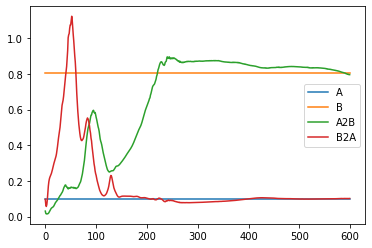

In [20]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()

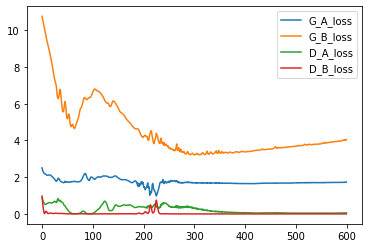

In [22]:
plt.plot(r2c_gan.history.track['train_G_A_loss'], label='G_A_loss')
plt.plot(r2c_gan.history.track['train_G_B_loss'], label='G_B_loss')
plt.plot(r2c_gan.history.track['train_D_A_loss'], label='D_A_loss')
plt.plot(r2c_gan.history.track['train_D_B_loss'], label='D_B_loss')
# plt.ylim(0, 4)
plt.legend()
plt.show()